# Planejamento da solução

#### Perguntas de negócio

1. Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
2. Qual a Performance do modelo em classificar os clientes como churns?
3. Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?

#### Como a empresa funciona
1. Receita = 15% * salário, se salário <= média
1. Receita = 20% * salário, se salário > média

####  Tasks

1. Ler os dados
2. Estudar os dados
3. Limpar os dados
4. Criar features
5. Selecionar as features mais importantes
6. Testar modelos de classificação
7. Melhorar os parâmetros
8. Fazer cross validation
9. Analisar performance do modelo
10. Traduzir o erro em resultado de negócio

#### Saída

1. Tabela de teste com clientes classificados se estão ou não em churn
2. Deploy no Heroku
3. API no Google Sheets
4. Relatório respondendo perguntas de negócio
5. Principais hipóteses da EDA em Tableau (talvez)



# 0.0. Imports

In [117]:
import pandas         as pd
import numpy          as np
import seaborn        as sns
import plotly.express as px
import scikitplot     as skplt
import pickle


from matplotlib import pyplot as plt

from sklearn              import preprocessing        as pp
from sklearn              import model_selection      as ms
from sklearn              import ensemble             as en
from sklearn              import metrics              as m
from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.neighbors    import KNeighborsClassifier 
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm             import LGBMClassifier

from xgboost import XGBClassifier

from boruta import BorutaPy




# 0.1. Helper Functions

In [118]:
def num_attributes(df1):
    
    num_attributes = df1.select_dtypes(['int64', 'float64'])

    #central tendency
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #dispersion
    d1 = pd.DataFrame(num_attributes.apply(np.min)).T
    d2 = pd.DataFrame(num_attributes.apply(np.max)).T
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d4 = pd.DataFrame(num_attributes.apply(np.std)).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    metrics = pd.concat( [d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
    metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
    return metrics

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
#     plt.style.use( 'ggplot')
#     plt.rcParams['figure.figsize'] = [24, 9]
#     plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set(font_scale = 3)
    sns.set()
    
jupyter_settings()

def order_data(x_val, y_val, yhat):
    
    #copy data of x_val
    data = x_val.copy()
    data['exited'] = y_val.copy()
    
    #get score
    data['score'] = yhat[:,1].tolist()
    data = data.sort_values('score', ascending=False)
    
    return data
    
def precision_at_k(data, k=300):

    #reset index
    data = data.reset_index(drop=True)

    #create ranking
    data['ranking'] = data.index + 1

    #create precision at k
    data['precision_at_k'] = data['exited'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def get_label(yhat,threshold=0.5):
    pred = yhat[:,1]
    response = (pred>=threshold).astype(int)
    return response

def cross_validation(X, y, model_name, model):    
    
    skf = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
    skf.get_n_splits(X, y)

    precision_list = []
    recall_list = []
    roc_score_list = []
    f1_list = []

    for train_index, test_index in skf.split(X, y):

        x_train_cv = X.iloc[train_index]
        y_train_cv = y.iloc[train_index]

        x_test_cv = X.iloc[test_index]
        y_test_cv = y.iloc[test_index]

        #model training
        model.fit(x_train_cv, y_train_cv)

        #model performance
        pred = model.predict(x_test_cv)

    
        #metrics to look into
        f1_list.append(m.f1_score(y_test_cv, pred))
        recall_list.append(m.recall_score(y_test_cv, pred))
        roc_score_list.append(m.roc_auc_score(y_test_cv, pred))
        precision_list.append(m.precision_score(y_test_cv, pred))
        
        f1_mean, f1_std = np.round(np.mean( f1_list),3), np.round(np.std(f1_list),3)
        recall_mean, recall_std = np.round(np.mean(recall_list),3), np.round(np.std(recall_list),3)
        roc_score_mean, roc_score_std = np.round(np.mean( roc_score_list),3), np.round(np.std(roc_score_list),3)
        precision_mean, precision_std = np.round(np.mean(precision_list),3),   np.round(np.std(precision_list),3)
        
        return  pd.DataFrame({'F1': '{} +/- {}'.format(f1_mean, f1_std),
                              'Recall': '{} +/- {}'.format(recall_mean, recall_std),
                              'Roc Score': '{} +/- {}'.format(roc_score_mean, roc_score_std),
                              'Precision': '{} +/- {}'.format(precision_mean, precision_std)},
                             index=[model_name])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [119]:
df_raw = pd.read_csv('../data/churn.csv')

# 1.0. Data Description

## 1.1. Rename Columns

In [120]:
df1=df_raw.copy()

df1.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.2. Data Shape

In [121]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 10000
Number of columns: 14


## 1.3. Data Types

In [122]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_products          int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4. Check NA

In [123]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_products        0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. FIll NA


No NA to replace

## 1.5. Descriptive Analysis

### 1.5.1. Num Attributes

In [124]:
metrics = num_attributes(df1)

#drop binary features
metrics = metrics.drop([0,1,7,8,10], axis=0)
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
2,credit_score,350.00,850.00,500.00,650.528800,652.000,96.648466,-0.071607,-0.425726
3,age,18.00,92.00,74.00,38.921800,37.000,10.487282,1.011320,1.395347
4,tenure,0.00,10.00,10.00,5.012800,5.000,2.892030,0.010991,-1.165225
5,balance,0.00,250898.09,250898.09,76485.889288,97198.540,62394.285254,-0.141109,-1.489412
6,num_products,1.00,4.00,3.00,1.530200,1.000,0.581625,0.745568,0.582981
9,estimated_salary,11.58,199992.48,199980.90,100090.239881,100193.915,57507.617221,0.002085,-1.181518


### 1.5.2. Categorical Attributes

In [125]:
cat_attributes = df1.drop(columns=['row_number', 'customer_id','credit_score', 'age', 'tenure', 'balance', 'num_products', 'estimated_salary'], axis=1)
cat_attributes.head()

,surname,geography,gender,has_cr_card,is_active_member,exited
0,Hargrave,France,Female,1,1,1
1,Hill,Spain,Female,0,1,0
2,Onio,France,Female,1,0,1
3,Boni,France,Female,0,0,0
4,Mitchell,Spain,Female,1,1,0


#### Surname

In [126]:
# cat_attributes['surname'].value_counts()

#### Gender

In [127]:
cat_attributes['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

#### Geography

In [128]:
cat_attributes['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

#### Credit Card

In [129]:
cat_attributes['has_cr_card'].value_counts()

1    7055
0    2945
Name: has_cr_card, dtype: int64

#### Active member

In [130]:
cat_attributes['is_active_member'].value_counts()

1    5151
0    4849
Name: is_active_member, dtype: int64

#### Exited (target)

In [131]:
cat_attributes['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

# 2.0. Data Filtering & Feature Engineering

In [132]:
df2 = df1.copy()


#drop row number
df2 = df2.drop('row_number', axis=1)

#balance salary
df2['balance/salary'] = df2['balance']/df2['estimated_salary']


# 3.0. Exploratory Data Analysis

In [133]:
df3 = df2.copy()

## 3.1. Unavariate Analisys

In [134]:
df_yes = df3[df3['exited'] == 1]
df_no = df3[df3['exited'] == 0]

df3.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited', 'balance/salary'],
      dtype='object')

### Age

In [135]:
fig = px.box(df3, x="exited", y="age")
fig.show()

In [136]:
# ditribution yes by age
fig = px.histogram(df_yes, x='age');
fig.show()

In [137]:
# ditribution no by age
fig = px.histogram(df_no, x='age');
fig.show()

In [138]:
# aux = df3[['customer_id','age', 'exited']].groupby(['age', 'exited']).count().rename(columns={'customer_id': 'n_customers'}).reset_index()

# fig = px.histogram(aux, x="age", y="n_customers", color="exited", marginal="rug",
#                    hover_data=aux.columns, nbins=30)
# fig.show()


The target feature is concentrated in middle age [40-50].

### Is active

In [23]:
df_yes['is_active_member'].value_counts(normalize=True)


0    0.639175
1    0.360825
Name: is_active_member, dtype: float64

In [24]:
aux = df3[['customer_id','is_active_member', 'exited']].groupby(['is_active_member', 'exited']).count().rename(columns={'customer_id': 'n_customers'}).reset_index()

fig = px.bar(aux, x="is_active_member", y="n_customers", color="exited", title="Active member distribution")
fig.show()


1/3 of inactive members exited, high correlation

### Geography

In [25]:
df_yes['geography'].value_counts(normalize=True)

Germany    0.399607
France     0.397644
Spain      0.202749
Name: geography, dtype: float64

In [26]:
aux = df3[['customer_id','geography', 'exited']].groupby(['geography', 'exited']).count().rename(columns={'customer_id': 'n_customers'}).reset_index()

fig = px.bar(aux, x="geography", y="n_customers", color="exited", title="Geography Distribution")
fig.show()



### Gender

In [27]:
aux = df3[['customer_id','gender', 'exited']].groupby(['gender', 'exited']).count().rename(columns={'customer_id': 'n_customers'}).reset_index()


fig = px.bar(aux, x="gender", y="n_customers", color="exited", title="Gender Distribution")
fig.show()


### Tenure

In [28]:
fig = px.box(df3, x="exited", y="tenure")
fig.show()


### Balance

In [29]:
fig = px.box(df3, x="exited", y="balance")
fig.show()


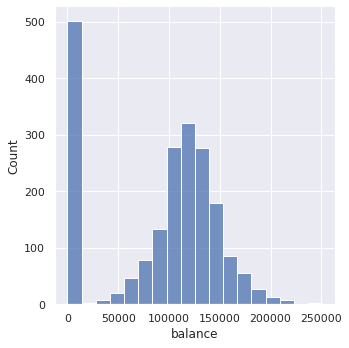

In [30]:
sns.displot(df_yes['balance']);

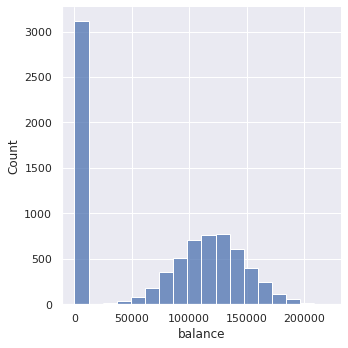

In [31]:
sns.displot(df_no['balance']);

Distribution is similar, but the amount is much larger in "no exit"

### Num Products

In [32]:
aux = df3[['customer_id','num_products', 'exited']].groupby(['num_products', 'exited']).count().rename(columns={'customer_id': 'n_customers'}).reset_index()

fig = px.bar(aux, x="num_products", y="n_customers", color="exited", title="Credit Card Distribution")
fig.show()



Customers with more than 2 products has high probability to exit

### Credit card

In [33]:
aux = df3[['customer_id','has_cr_card', 'exited']].groupby(['has_cr_card', 'exited']).count().rename(columns={'customer_id': 'n_customers'}).reset_index()

fig = px.bar(aux, x="has_cr_card", y="n_customers", color="exited", title="Credit Card Distribution")
fig.show()

A lot more has exited with credit card. More than 2 times the number. 

### Estimated Salary

In [34]:
fig = px.box(df3, x='exited', y='estimated_salary')
fig.show()

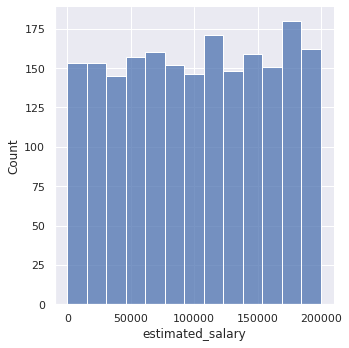

In [35]:
sns.displot(df_yes['estimated_salary']);

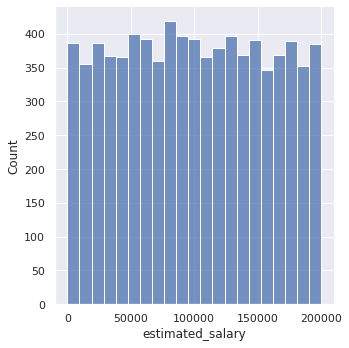

In [36]:
sns.displot(df_no['estimated_salary']);

There are low correlation to the target, but we could analyse this combined with another feature.

1. Gender
1. Age

## 3.2. Bivariate Analysis

Comparing two features with the target feature

### Age & Gender

In [37]:
aux = df_yes[['customer_id', 'gender', 'age']].groupby(['gender', 'age']).count().rename(columns={'customer_id':'n_customers'}).reset_index()


fig = px.histogram(aux, x="age", y="n_customers", color="gender",
                   hover_data=aux.columns)
fig.show()

In [38]:
aux = df_no[['customer_id', 'gender', 'age']].groupby(['gender', 'age']).count().rename(columns={'customer_id':'n_customers'}).reset_index()


fig = px.histogram(aux, x="age", y="n_customers", color="gender",
                   hover_data=aux.columns)
fig.show()

Churn is higher in female gender

### Gender & Balance/Salary

In [39]:
aux = df_yes[['customer_id', 'gender', 'balance']].groupby(['gender', 'balance']).count().rename(columns={'customer_id':'n_customers'}).reset_index()


fig = px.histogram(aux, x="balance", y="n_customers", color="gender",
                   hover_data=aux.columns)
fig.show()

In [40]:
aux = df_yes[['customer_id', 'gender', 'estimated_salary']].groupby(['gender', 'estimated_salary']).count().rename(columns={'customer_id':'n_customers'}).reset_index()


fig = px.histogram(aux, x="estimated_salary", y="n_customers", color="gender",
                   hover_data=aux.columns)
fig.show()

## 3.3. Multivariate Analysis

In [41]:

num_attributes = df3.select_dtypes(['int64', 'float64'])
correlation = num_attributes.corr(method='pearson' )

fig = px.imshow(correlation)
fig.show()

## 3.4. Conclusion

1. Univariate Analysis

* Female exit more than male
* Middle age (40 - 50) exit more
* (0-40) age exit less 
* 1/3 of Inactive member exited
* Spanish customers exited less, German and French exited in same proportion
* Tenure has normal distribution in positive and negative exit (not important)
* Distribution of Balance has kurtosis lower in exited customers
* Customers with more than 2 products has high probability to exit
* A lot more has exited with credit card. More than 2 times the number. But there are low correlation.
* Estimated salary has the same distribution. Low correlation.



2. Bivariate Analysis
* Female exit more, no matter the age
* Female exit more, no matter the balance
* Female exit more, no matter the salary

3. Multivariate Analysis

1.1. High Correlation:
* Age vs exited
* Active member vs exited

2.2. Medium Correlation
* Balance vs exited

4. Result Boruta

['credit_score', 'age', 'balance', 'num_products']

# 4.0. Data Preparation

## 4.1. Define Scalers

In [139]:
df4 = df3.drop('surname', axis=1).copy()



In [140]:
mms = pp.MinMaxScaler()
ss = pp.StandardScaler()
rs = pp.RobustScaler

## 4.2. Scaling

In [141]:
# -----scaler----

#credit_score
df4['credit_score'] = mms.fit_transform(df4[['credit_score']] )

#age  -- normal dist
df4['age'] = mms.fit_transform(df4[['age']] )

#tenure
df4['tenure'] = mms.fit_transform(df4[['tenure']] )

#balance
df4['balance'] = mms.fit_transform(df4[['balance']] )

#num_products
df4['num_products'] = mms.fit_transform(df4[['num_products']] )

#estimated salary
df4['estimated_salary'] = mms.fit_transform(df4[['estimated_salary']] )


## 4.3. Encoding

In [142]:



#geography ==> One Hot
df4 = pd.get_dummies(df4, prefix='geography', columns=['geography'])


#Gender ==> Target Encoder
target_encode_gender = df4.groupby('gender')['exited'].mean()
df4.loc[:,'gender'] = df4['gender'].map(target_encode_gender)
# pickle.dump(target_encode_gender, open('../features/target_encoder_gender.pkl', 'wb'))

In [143]:
X = df4.drop(['exited','customer_id'], axis=1)
y = df4['exited']

X_train, X_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

# 5.0. Feature Selection

In [144]:
X_train.head()

,credit_score,gender,age,tenure,balance,num_products,has_cr_card,is_active_member,estimated_salary,balance/salary,geography_France,geography_Germany,geography_Spain
5707,0.792,0.164559,0.094595,0.9,0.000000,0.333333,0,1,0.443627,0.000000,1,0,0
2455,0.622,0.164559,0.391892,0.5,0.000000,0.000000,0,1,0.536210,0.000000,1,0,0
2257,0.672,0.250715,0.229730,0.4,0.000000,0.333333,1,1,0.798401,0.000000,0,0,1
9420,0.614,0.250715,0.135135,0.7,0.000000,0.333333,0,1,0.025833,0.000000,1,0,0
2983,0.346,0.164559,0.229730,0.8,0.553144,0.000000,1,1,0.930626,0.745667,0,1,0


## 5.1. Boruta

In [145]:
# #array transform
# X_train_n = X_train.drop('customer_id', axis=1).values
# y_train_n = y_train.values


# #define random forest
# rf = RandomForestClassifier(n_jobs=-1, random_state=3)

# #define Boruta
# feat_selector = BorutaPy(rf, n_estimators=300, verbose=2, random_state=1).fit(X_train_n, y_train_n)




In [146]:
# cols_selected = feat_selector.support_.tolist()


# X_train_fs = X_train.drop('customer_id', axis=1)

# cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.tolist()
# cols_not_selected_boruta = list(np.setdiff1d(X_train.columns, cols_selected_boruta))
# cols_not_selected_boruta



## 5.2. Extra Trees

In [147]:
# #model definition
# forest = en.ExtraTreesClassifier(n_estimators=250, random_state=3, n_jobs=-1)


# #data preparation
# x_train_n = X_train
# y_train_n = y_train.values
# forest.fit(x_train_n, y_train_n)

# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]

# #print the feature ranking
# print('Feature ranking:')
# df = pd.DataFrame()
# for i, j in zip(x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature':i, 'importance': j},index=[0])
#     df = pd.concat([df,aux],axis=0)
    
# print(df.sort_values('importance', ascending=False))

## Plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title('Feature Importances')
# plt.bar(range(x_train_n.shape[1]),importances[indices], color='r', yerr=std[indices], align='center')
# plt.xticks(range(x_train_n.shape[1]),indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show()

## 5.2 Select Features Manually

In [148]:
# cols_selected_boruta = ['age', 'balance', 'num_products', 'credit_score', 'estimated_salary']

In [149]:
cols_selected_boruta = ['age', 'balance', 'credit_score', 'estimated_salary']

In [150]:
cols_not_selected_boruta = ['balance/salary',
 'credit_score',
 'customer_id',
 'gender',
 'geography_France',
 'geography_Germany',
 'geography_Spain',
 'has_cr_card',
 'is_active_member',
 'tenure']

In [151]:
#adding some features by results of EDA 

# cols_selected_boruta.append('gender')
# cols_selected_boruta.append('is_active_member')
cols_selected_boruta

['age', 'balance', 'credit_score', 'estimated_salary']

# 6.0. Model Training

In [55]:
X_train = X_train[cols_selected_boruta]
X_validation = X_validation[cols_selected_boruta]

X_validation.head()

,age,balance,num_products,credit_score,estimated_salary
227,0.283784,0.297317,0.666667,0.394,0.428716
6096,0.310811,0.628851,0.000000,0.584,0.337397
3063,0.189189,0.286460,0.000000,0.518,0.759639
4886,0.472973,0.493447,0.000000,0.722,0.512134
8247,0.094595,0.455439,0.333333,0.310,0.633644


## 6.1. KNN

In [153]:
#model definition
knn_model = KNeighborsClassifier(n_neighbors=3 ) 

#model train
knn_model.fit(X_train, y_train)


#model performance - poder de generalização
yhat_knn = knn_model.predict_proba(X_validation)


### Precision Cross Validation

In [154]:
knn_result = cross_validation(X, y, 'KNN', knn_model)

### Confusion Matrix

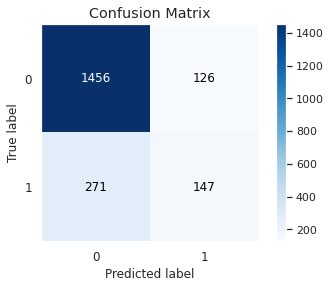

In [155]:
pred_knn = get_label(yhat_knn, threshold=0.5)
skplt.metrics.plot_confusion_matrix(y_validation, pred_knn);


## 6.2. Logistic Regressor

In [156]:
#model definition
lr_model = LogisticRegression( random_state=2)

#model training
lr_model.fit(X_train, y_train)

#model performance
yhat_lr = lr_model.predict(X_validation)
yhat_lr

/home/heitor/repos/client_churn_prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



array([0, 0, 0, ..., 0, 0, 0])

### Cross Validation

In [157]:
lr_result = cross_validation(X, y, 'Logistic Regressor', lr_model)

/home/heitor/repos/client_churn_prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Confusion Matrix

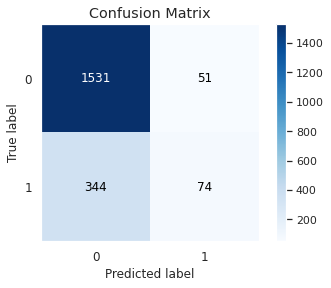

In [158]:
# pred_lr = get_label(yhat_lr, threshold=0.2)
skplt.metrics.plot_confusion_matrix(y_validation, yhat_lr);


## 6.3. XGBClassifier

In [159]:
#model definition
xgb_model =  XGBClassifier(random_state=42, scale_pos_weight=4)

#model training
xgb_model.fit(X_train, y_train)

#model performance
yhat_xgb = xgb_model.predict(X_validation)



/home/heitor/repos/client_churn_prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/home/heitor/repos/client_churn_prediction/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[06:09:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Precision Cross Validation

In [160]:
xgb_result = cross_validation(X, y, 'XGB Classifier', xgb_model)

/home/heitor/repos/client_churn_prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/home/heitor/repos/client_churn_prediction/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[06:09:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Confusion Matrix

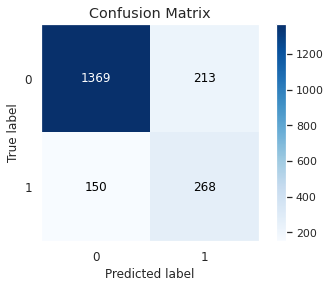

In [161]:

skplt.metrics.plot_confusion_matrix(y_validation, yhat_xgb);


## 6.4. Random Forest Classifier

In [162]:

#model definition
rf_model = en.RandomForestClassifier(n_estimators=500)

#model training
rf_model.fit(X_train, y_train)

#model predict
yhat_rf = rf_model.predict(X_validation)



### Cross Validation

In [163]:
rf_result = cross_validation(X, y, 'Random Forest Classifier' ,rf_model)

### Confusion Matrix

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

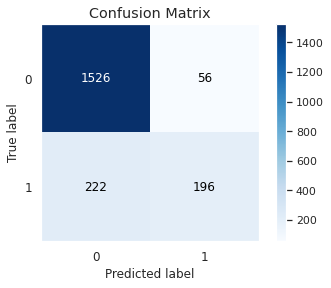

In [164]:
skplt.metrics.plot_confusion_matrix(y_validation, yhat_rf)

## 6.4. Support Vector Machine

In [165]:

#model definition
svm_model = SVC(class_weight='balanced', random_state=5)

# #model training
svm_model.fit(X_train, y_train)

# #model predict
yhat_svm = svm_model.predict(X_validation)




In [166]:
m.f1_score(y_validation, yhat_svm)

0.05639913232104122

### Cross Validation

In [167]:
svm_result = cross_validation(X, y, 'Support Vector Machine' ,svm_model)

### Confusion Matrix

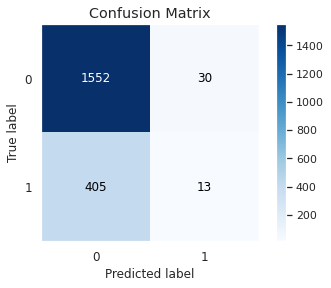

In [168]:
skplt.metrics.plot_confusion_matrix(y_validation, yhat_svm);

## 6.6. LightGBM Classifier

In [169]:

#model definition
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=3)

# #model training
lgbm_model.fit(X_train, y_train)

# #model predict
yhat_lgbm = lgbm_model.predict(X_validation)



### Cross Validation

In [170]:
lgbm_result = cross_validation(X, y, 'LGBM Classifier' ,lgbm_model)

### Confusion Matrix

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

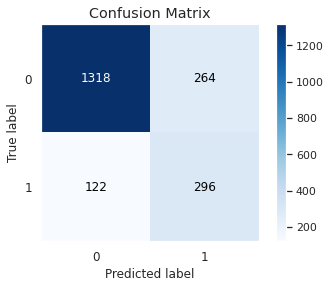

In [171]:
skplt.metrics.plot_confusion_matrix(y_validation, yhat_lgbm)

## 6.7. Comparing Models Performance

In [172]:
results = pd.concat([knn_result, lr_result, xgb_result, rf_result, svm_result, lgbm_result])

results.style.highlight_max(color='lightgreen', axis=1)

,F1,Recall,Roc Score,Precision
KNN,0.422 +/- 0.0,0.353 +/- 0.0,0.636 +/- 0.0,0.526 +/- 0.0
Logistic Regressor,0.302 +/- 0.0,0.199 +/- 0.0,0.585 +/- 0.0,0.633 +/- 0.0
XGB Classifier,0.603 +/- 0.0,0.63 +/- 0.0,0.756 +/- 0.0,0.579 +/- 0.0
Random Forest Classifier,0.593 +/- 0.0,0.478 +/- 0.0,0.722 +/- 0.0,0.78 +/- 0.0
Support Vector Machine,0.064 +/- 0.0,0.037 +/- 0.0,0.505 +/- 0.0,0.259 +/- 0.0
LGBM Classifier,0.614 +/- 0.0,0.696 +/- 0.0,0.775 +/- 0.0,0.549 +/- 0.0


# 7.0. Hyperparameter Fine Tuning

In [178]:
#dict with the parameters list
import random

import warnings
warnings.filterwarnings("ignore")
param = {
    'n_estimators': [ 1000, 1200, 1500, 2000, 2500],
    'eta': [0.03, 0.05, 0.08, 0.1, 0.12],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.5, 0.7, 0.9,],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'min_child_weight': [3, 5, 7]
}

#max combinations
MAX_EVAL  = 5

#results dataframe
results = pd.DataFrame()

#set a random seed
random.seed(3)


#random combine
for i in range(MAX_EVAL):
    # choose values for parameters randomly
    #
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    #
    print('\n')
    print( hp )

    #model definition
    model_xgb = XGBClassifier(n_estimators=hp['n_estimators'],
                              eta = hp['eta'],
                              max_depth = hp['max_depth'],
                              subsample = hp['subsample'],
                              colsample_bytree = hp['colsample_bytree'],
                              min_child_weight = hp['min_child_weight'], 
                              random_state=42
                              
    )
    
    
    #model training & performance

    print(cross_validation(X, y, 'XGBClassifier',model_xgb))
    



{'n_estimators': 1200, 'eta': 0.12, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 1.0, 'min_child_weight': 5}
[06:14:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                         F1         Recall      Roc Score      Precision
XGBClassifier  0.56 +/- 0.0  0.485 +/- 0.0  0.711 +/- 0.0  0.662 +/- 0.0


{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 7}
[06:15:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                          F1        Recall      Roc Score     Precision
XGBClassifier  0.604 +/- 0.0  0.51 +/-

In [174]:

# param = {'n_estimators': 2500,
#          'eta': 0.03,
#          'max_depth': 3,
#          'subsample': 0.7,
#          'colsample_bytree': 0.9,
#          'min_child_weight': 7}


xgb_tuned_model = XGBClassifier(n_estimators= 2500,
         eta= 0.03,
         max_depth= 3,
         subsample= 0.7,
         colsample_bytree= 0.9,
         min_child_weight= 7)

In [177]:
cross_validation(X, y, 'XGBClassifier',xgb_tuned_model)


/home/heitor/repos/client_churn_prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/home/heitor/repos/client_churn_prediction/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[06:13:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,F1,Recall,Roc Score,Precision
XGBClassifier,0.592 +/- 0.0,0.495 +/- 0.0,0.725 +/- 0.0,0.735 +/- 0.0


In [179]:
XGBClassifier?